In [54]:
#####Path-Based Relevance from a Probabilistic Perspective#####
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import scipy
from scipy import stats
from scipy import special
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *

#np.random.seed(98537)

In [55]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    if pattern==1:
        z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id

In [86]:
####データの生成####
##データの設定
edges = 15
k1 = 10
k2 = 10
hh = 1500

In [57]:
##IDとインデックスの設定
#IDの設定
target = np.triu(np.full((hh, hh), 1), k=1)
d_id1 = np.repeat(np.arange(hh), hh).reshape(hh, hh)[target==1]
d_id2 = np.repeat(np.arange(hh), hh).reshape(hh, hh, order="F")[target==1]
N = d_id1.shape[0]
no = np.arange(N)

#インデックスの設定
d_list1 = [i for i in range(hh)]
d_list2 = [i for i in range(hh)]
for i in range(hh):
    d_list1[i] = np.array(np.where(d_id1==i)[0], dtype="int")
    d_list2[i] = np.array(np.where(d_id2==i)[0], dtype="int")

In [58]:
####応答変数を生成####
rp = 0
while True:
    rp = rp + 1
    
    ##パラメータの生成
    #事前分布の設定
    alpha1 = 3.5; beta1 = 2.0
    alpha2 = 1/1.25; beta2 = 1.25
    alpha3 = 1/1.0; beta3 = 1.0

    #モデルパラメータを生成
    theta = np.random.dirichlet(np.repeat(0.25, k1), N)
    pi = np.random.gamma(alpha1, 1/beta1, edges)
    gamma = np.random.gamma(alpha2, 1/beta2, hh*k2).reshape(hh, k2)
    phi = np.random.gamma(alpha3, 1/beta3, k1*edges).reshape(edges, k1)
    thetat = theta.copy(); pit = pi.copy(); gammat = gamma.copy(); phit = phi.copy()
    
    ##edgeごとにノード距離を生成
    z = np.zeros((N, edges), dtype="int16")
    y = np.zeros((N, edges), dtype="int")
    uv = np.sum(gamma[d_id1]*gamma[d_id2], axis=1)
    
    for j in range(edges):
        #トピックを生成
        z[:, j] = np.array(rmnom(theta, N, k1, np.arange(N), 0), dtype="int16")

        #指数分布から応答変数を生成
        mu = pi[j] * uv * phi[j, ][z[:, j]]
        y[:, j] = np.random.poisson(mu, N)
    Z = z.copy()
    
    #break条件
    print([rp, np.max(y)])
    if (np.max(y) < 1000) & (np.max(y) > 250):
        break

[1, 496]


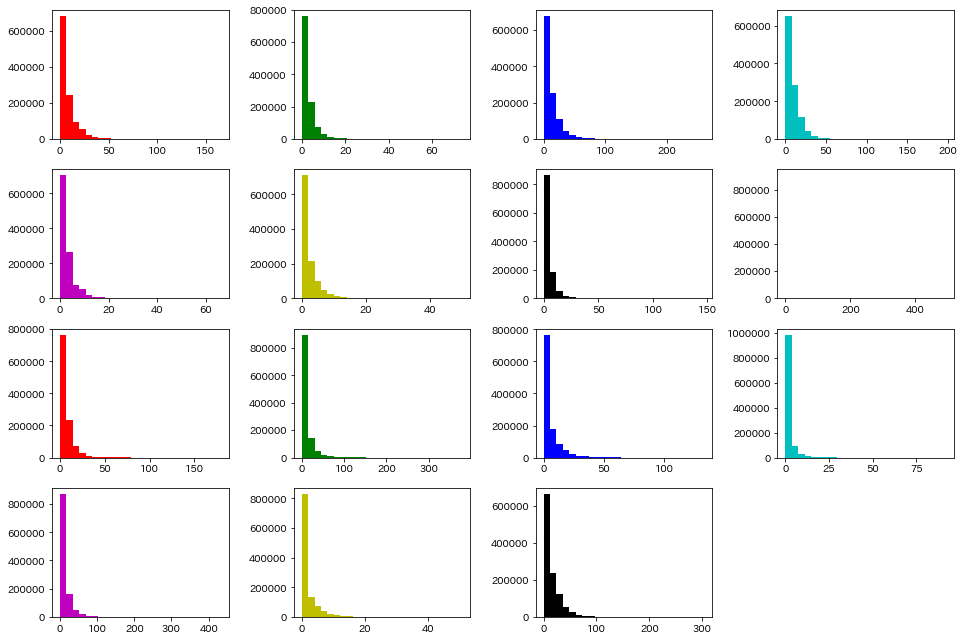

In [59]:
#生成したデータを可視化
dt = [y[:, j] for j in range(edges)]
fig_range = np.append(np.min(y, axis=0), np.max(y, axis=0)).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w", "r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure(figsize=(13.5, 9.0))
for j in range(len(dt)):
    ax = fig.add_subplot(4, 4, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
fig.tight_layout()
plt.show()

In [80]:
####マルコフ連鎖モンテカルロ法でパラメータを推定####
##アルゴリズムと定数の設定
#アルゴリズムの設定
R = 1000
keep = 2
burnin = int(250/keep)
iter = 0
disp = 10
L = 3

#定数の設定
k_vec1 = np.repeat(1.0, k1)
k_vec2 = np.repeat(1.0, k2)
lfactorial_y1 = scipy.special.gammaln(y + 1)
y_vec = [j for j in range(edges)]
lfactorial_y2 = [j for j in range(edges)]
for j in range(edges):
    y_vec[j] = y[:, j][:, np.newaxis]
    lfactorial_y2[j] = lfactorial_y1[:, j][:, np.newaxis]

In [139]:
#事前分布の設定
alpha = 0.1
alpha1 = 0.25; beta1 = 0.5
alpha2 = 0.25; beta2 = 0.5
alpha3 = 0.25; beta3 = 0.5

In [205]:
##パラメータの真値
#モデルパラメータの真値
theta = thetat.copy()
pi = pit.copy()
gamma = gammat.copy()
phi = phit.copy()
z = Z.copy()

#期待値の真値
mu = np.zeros((N, edges))
uv = np.sum(gamma[d_id1]*gamma[d_id2], axis=1)
for j in range(edges):
    mu[:, j] = pi[j] * uv * phi[j, ][z[:, j]]
mut = mu.copy()

In [206]:
##パラメータの初期値
#モデルパラメータの初期値
theta = np.random.dirichlet(np.repeat(2.5, k1), N)
pi = np.random.gamma(3.0, 1/2.0, edges)
gamma = np.random.gamma(1.0, 1.5, hh*k2).reshape(hh, k2)
phi = np.random.gamma(1.0, 1.5, k1*edges).reshape(edges, k1)

#パラメータを更新
gamma_vec1 = gamma[d_id1, ]; gamma_vec2 = gamma[d_id2, ]
uv_deploy = gamma_vec1 * gamma_vec2
uv = np.sum(uv_deploy, axis=1)
z = np.zeros((N, edges), dtype="int16")
for j in range(edges):
    z[:, j] = np.array(rmnom(theta, N, k1, np.arange(N), 0), dtype="int16")

#期待値の初期値
mu = np.zeros((N, edges), dtype="int")
uv = np.sum(gamma[d_id1]*gamma[d_id2], axis=1)
for j in range(edges):
    mu = pi[j] * uv * phi[j, ][z[:, j]]

In [207]:
##パラメータの格納用配列
THETA = np.zeros((N, k1))
PI = np.zeros((int(R/keep), edges))
GAMMA = np.zeros((hh, k2, int(R/keep)))
PHI = np.zeros((edges, k1, int(R/keep)))

In [208]:
##対数尤度の基準値
#学習データの1パラメータモデルの対数尤度
LLst = np.sum(y*np.log(np.mean(y, axis=0)) - np.mean(y, axis=0) - lfactorial_y1)
print(LLst)

#学習データの真値の対数尤度
LLbest = np.sum(y*np.log(mut) - mut - lfactorial_y1)
print(LLbest)

-90863550.51957968
-32033821.07770104


In [209]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##重みパラメータをサンプリング
    #事後分布のパラメータ
    lambda_h = np.repeat(0.0, edges)
    for j in range(edges):
        lambda_h[j] = np.sum(phi[j, ][z[:, j]] * uv)
    W1 = np.sum(y, axis=0) + alpha1; W2 = lambda_h + beta1

    #ガンマ分布から事後分布をサンプリング
    pi = np.random.gamma(W1, 1/W2)


    ##トピックと対応するパラメータをサンプリング
    #トピックの格納用配列
    Zi = np.zeros((N, k1), dtype="int16")

    for j in range(edges):
        #トピックをサンプリング
        mu = pi[j] * phi[j, ] * uv[:, np.newaxis]
        Lho = theta * np.exp(y_vec[j]*np.log(mu) - mu - lfactorial_y2[j])
        Prob = Lho / np.dot(Lho, k_vec1)[:, np.newaxis]
        out = rmnom(Prob, N, k1, no, 1)
        topic = np.array(out[1].todense(), dtype="int")
        Zi += topic
        z[:, j] = np.array(out[0], dtype="int16")

        #ガンマ分布から事後分布をサンプリング
        W1 = np.sum(y_vec[j] * topic, axis=0) + alpha2
        W2 = np.sum(pi[j] * uv[:, np.newaxis] * topic, axis=0) + beta2
        phi[j, ] = np.random.gamma(W1, 1/W2)

    #ディリクレ分布からトピック分布をサンプリング
    wsum = Zi + alpha
    for i in range(N):
        theta[i, ] = np.random.dirichlet(wsum[i, ], 1)


    ##ユーザー特徴ベクトルをサンプリング
    #パラメータの定義
    gamma_vec1 = gamma[d_id1, ]; gamma_vec2 = gamma[d_id2, ]
    uv_deploy = gamma_vec1 * gamma_vec2
    uv = np.sum(uv_deploy, axis=1)

    #パラメータの格納用配列
    mu = np.zeros((N, edges))
    weights = np.zeros((N, edges))
    Lambda = [j for j in range(edges)]
    lambda_y = [j for j in range(edges)]
    lambda_h1 = [j for j in range(edges)]
    lambda_h2 = [j for j in range(edges)]

    #期待値と補助変数の更新
    for j in range(edges):
        weights[:, j] = pi[j] * phi[j, ][z[:, j]]
        weights_vec = weights[:, j][:, np.newaxis]
        mu[:, j] = weights[:, j] * uv    
        Lambda[j] = (weights_vec * uv_deploy) / mu[:, j][:, np.newaxis]
        lambda_y[j] = Lambda[j] * y_vec[j]
        lambda_h1[j] = weights_vec * gamma_vec2
        lambda_h2[j] = weights_vec * gamma_vec1

    #事後分布のパラメータ
    W1 = np.zeros((hh, k2)); W2 = np.zeros((hh, k2))
    for i in range(hh):
        index1 = d_list1[i]; index2 = d_list2[i]
        for j in range(edges):
            W1[i, ] += np.sum(np.vstack((lambda_y[j][index1, ], lambda_y[j][index2, ])), axis=0)
            W2[i, ] += np.sum(np.vstack((lambda_h1[j][index1, ], lambda_h2[j][index2, ])), axis=0)
    W1 = W1 + alpha3; W2 = W2 + beta3

    #ガンマ分布から事後分布をサンプリング
    gamma = np.random.gamma(W1, 1/W2)

    #パラメータを更新
    gamma_vec1 = gamma[d_id1, ]; gamma_vec2 = gamma[d_id2, ]
    uv_deploy = gamma_vec1 * gamma_vec2
    uv = np.sum(uv_deploy, axis=1)


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        THETA += theta
        PI[mkeep, ] = pi
        GAMMA[:, :, mkeep] = gamma
        PHI[:, :, mkeep] = phi

    if rp%disp==0:
        #学習データに対する対数尤度
        mu = np.zeros((N, edges))
        uv = np.sum(gamma[d_id1]*gamma[d_id2], axis=1)
        for j in range(edges):
            mu[:, j] = pi[j] * uv * phi[j, ][z[:, j]]
        LL = np.sum(y*np.log(mu) - mu - lfactorial_y1)

        #サンプリング結果を表示
        print(rp)
        print(np.round([LL, LLst, LLbest], 1))

0
[-38288536.8 -90863550.5 -32033821.1]
10
[-34471948.4 -90863550.5 -32033821.1]
20
[-34206965.  -90863550.5 -32033821.1]
30
[-34054223.3 -90863550.5 -32033821.1]
40
[-33960046.5 -90863550.5 -32033821.1]
50
[-33888913.6 -90863550.5 -32033821.1]
60
[-33842979.8 -90863550.5 -32033821.1]
70
[-33807047.8 -90863550.5 -32033821.1]
80
[-33746616.  -90863550.5 -32033821.1]
90
[-33710291.2 -90863550.5 -32033821.1]
100
[-33681697.3 -90863550.5 -32033821.1]
110
[-33632395.1 -90863550.5 -32033821.1]
120
[-33591565.9 -90863550.5 -32033821.1]
130
[-33563456.1 -90863550.5 -32033821.1]
140
[-33534927.9 -90863550.5 -32033821.1]
150
[-33498507.4 -90863550.5 -32033821.1]
160
[-33474439.  -90863550.5 -32033821.1]
170
[-33449098.4 -90863550.5 -32033821.1]
180
[-33426127.7 -90863550.5 -32033821.1]
190
[-33403325.2 -90863550.5 -32033821.1]
200
[-33390778.4 -90863550.5 -32033821.1]
210
[-33370690.1 -90863550.5 -32033821.1]
220
[-33353880.3 -90863550.5 -32033821.1]
230
[-33333959.8 -90863550.5 -32033821.1]
240